## 7B. Adversarial training

Spriha Jha (net ID)

---

Replace the "Title" text above with the title of your project, and replace the "Name" and "net ID" with the name(s) and net ID(s) of all the team members.

Also replace the "[Project Title]" text in the notebook title.

Then, delete this cell.

---

## Background

---

Instructions: In this section, add text cells and write 4-10 paragraphs about the technique, model, or dataset that is the topic of your project. 

This can include, but does not have to include/is not limited to, the following: what is it, how is it used, why is it important, what are some interesting details people should know about it, what are the challenges that this work addresses, what is the "new" contribution of this work compared to the pre-existing work, what are its disadvantages and limitations. Etc.

This text:

* 🚫 **should not be copied directly from any source**. 
  * If you copy verbatim from another source without a proper citation, it is a violation of academic integrity and the project will earn a zero grade. 
  * If you copy verbatim from another source *with* a proper citation, it's not a violation of academic integrity - but it still won't earn a good grade, because I am not asking for a direct quote here.
* 🚫 **should not be a direct paraphrase from any source, either** - A direct paraphrase is when you take a chunk of text from an existing source, and then re-write it in different words. 
 * If you do this without a proper citation, it is a violation of academic integrity and the project will earn a zero grade. 
 * If you do this with citation, it is not a violation of academic integrity - but it still won't  earn a good grade, because it's not what I am asking for here. A direct paraphrase shows that you can write in English, but doesn't show that you understood what you are writing! (In fact, there are many ML models that can paraphrase arbitrary text for you - they don't need to "understand" the text to paraphrase it.)
* ✅ **should summarize and synthesize content from multiple parts of the main paper and/or from multiple sources in your own words, and cite sources**. 
  * Your work should show that you really understand what you read, and are able to critically pick out the important elements, then explain them and put them together in a way that makes sense of it all.
  * You should show the ability to use additional high-quality sources in order to understand the main paper, if necessary. If you use outside sources (beyond the "main paper" that your project is about), make sure to cite them, too.
  * You still need to cite the source of the ideas that you are writing about, even if you write about them in your own words.
  * When citing sources, it's not enough to just have a list of references at the end. You also need to show how and where you used those references, by adding appropriate *in-text citations*.
  * If you include equations from any outside source (the "main paper" or any other source), make sure to cite them. (Don't paraphrase equations. But DO explain them in your own words!)
  * If you include images (e.g. diagrams) in this section, make sure to cite sources too. Underneath each image, either 
    * cite the source if it is copied directly, e.g.: "Image from [3]".
    * cite the source if it is based on an image you saw somewhere else, but you drew it yourself or modified an existing image. e.g. "Image adapted from [6]".
    * if you created an image yourself and it's not based on any existing image you saw, explicitly mention that. e.g. "Image is original work". 


(here's a quick video about the difference between quoting, paraphrasing, and synthesizing: https://www.youtube.com/watch?v=mhtxm5CSwUs) 

Delete this cell of instructions after you have finished this section.

---

## Working with the existing code

---

In this section, you will include the code that you were given as a starting point.

At the top of this section, add a text cell:

* citing the exact source of the code
* explaining **in your own words** (an original summary, not a direct quote or paraphase - see above) what the code does.
* and describing any changes you had to make to get it to run. (For example: "To get this to run, I had to install `foo` version 5.9, since the code does not work with the latest version 5.60. I also had to change references to `foo.bar()` to instead say `foo.bar.x()`, to reflect a change in the `foo` library."

Then, the rest of this section can be code cells + code output cells. These will be assumed to be copied from the existing code you were given as a starting point.

Delete this cell of instructions after you have finished this section.

---

## 1. Load prereqs and data

In [1]:
!pip install adversarial-robustness-toolbox
!pip install adversarial-robustness-toolbox[tensorflow]

import tensorflow as tf

tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')

## 2. Train and evaluate a baseline classifier
Load the classifier model:

In [3]:
path = get_file('mnist_cnn_original.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/p2nyzne9chcerid/mnist_cnn_original.h5?dl=1')
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False)

In [4]:
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               2

Evaluate the classifier performance on the first 100 original test samples:

In [5]:
x_test_pred = np.argmax(classifier.predict(x_test[:100]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(100-nb_correct_pred))

Original test data (first 100 images):
Correctly classified: 100
Incorrectly classified: 0


Generate some adversarial samples:

In [6]:
attacker = FastGradientMethod(classifier, eps=0.5)
x_test_adv = attacker.generate(x_test[:100])

And evaluate performance on those:

In [7]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))

print("Adversarial test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(100-nb_correct_adv_pred))

Adversarial test data (first 100 images):
Correctly classified: 22
Incorrectly classified: 78


## 3. Adversarially train a robust classifier

In [8]:
path = get_file('mnist_cnn_robust.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1')
robust_classifier_model = load_model(path)
robust_classifier = KerasClassifier(clip_values=(min_, max_), model=robust_classifier_model, use_logits=False)

Note: the robust classifier has the same architecture as above, except the first dense layer has 1024 instead of 128 units. (This was recommend by Madry et al. (2017), Towards Deep Learning Models Resistant to Adversarial Attacks)

In [9]:
robust_classifier_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)             

Also as recommended by Madry et al., we use BIM/PGD attacks during adversarial training:

In [10]:
attacks = BasicIterativeMethod(robust_classifier, eps=0.3, eps_step=0.01, max_iter=40)

Perform adversarial training:

In [11]:
# We had performed this before, starting with a randomly initialized model.
# Adversarial training takes about 80 minutes on an NVIDIA V100.
# The resulting model is the one loaded from mnist_cnn_robust.h5 above.

# Here is the command we had used for the Adversarial Training

# trainer = AdversarialTrainer(robust_classifier, attacks, ratio=1.0)
# trainer.fit(x_train, y_train, nb_epochs=83, batch_size=50)

## 4. Evaluate the robust classifier
Evaluate the robust classifier's performance on the original test data:

In [12]:
x_test_robust_pred = np.argmax(robust_classifier.predict(x_test[:100]), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(100-nb_correct_robust_pred))

Original test data (first 100 images):
Correctly classified: 99
Incorrectly classified: 1


Evaluate the robust classifier's performance on the adversarial test data (white-box setting):

In [13]:
attacker_robust = FastGradientMethod(robust_classifier, eps=0.5)
x_test_adv_robust = attacker_robust.generate(x_test[:100])

In [14]:
x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
nb_correct_adv_robust_pred = np.sum(x_test_adv_robust_pred == np.argmax(y_test[:100], axis=1))

print("Adversarial test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_robust_pred))
print("Incorrectly classified: {}".format(100-nb_correct_adv_robust_pred))

Adversarial test data (first 100 images):
Correctly classified: 79
Incorrectly classified: 21


Compare the performance of the original and the robust classifier over a range of `eps` values:

In [15]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_correct_original = []
nb_correct_robust = []

for eps in eps_range:
    attacker.set_params(**{'eps': eps})
    attacker_robust.set_params(**{'eps': eps})
    x_test_adv = attacker.generate(x_test[:100])
    x_test_adv_robust = attacker_robust.generate(x_test[:100])
    
    x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
    nb_correct_original += [np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))]
    
    x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    nb_correct_robust += [np.sum(x_test_adv_robust_pred == np.argmax(y_test[:100], axis=1))]

eps_range = [0] + eps_range
nb_correct_original = [nb_correct_pred] + nb_correct_original
nb_correct_robust = [nb_correct_robust_pred] + nb_correct_robust

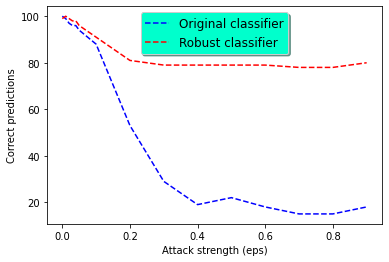

In [16]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Correct predictions')
plt.show()

## Validating a claim

---

In this section, you will validate a claim from the original work.

At the top of this section, add a text cell:

* explaining in your own words what claim in the original work you choose to validate, why you thought this would be interesting or useful, and what you learned from it.
* briefly discussing the results.
* and explaining any outside sources you used, and how you used them. For example, if your paper is about "Model A" and you chose to build on it by adding a comparison to "Model B", and you used some code you found online for "Model B", you should explain where the code for "Model B" came from and how you used it/adapted it.

Then, the rest of this section can be code cells + code output cells. These will be assumed to be **original work** unless stated otherwise. In **every single code cell** that is copied or adapted from another source, you must add a citation as a comment at the top of the cell.

I should be able to generate all of your results just by running each of the notebook cells in sequence. In case your project requires data to be uploaded to the workspace, use `git`, `wget`, `gdown`, or another tool to retrieve them directly - don't require me to upload data to the notebook.

Delete this cell of instructions after you have finished this section.


---

## 1. Loading prerequisites and data

In [17]:
!pip install adversarial-robustness-toolbox
!pip install adversarial-robustness-toolbox[tensorflow]

import tensorflow as tf

from keras.models import load_model

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np

from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, BasicIterativeMethod
from art.estimators.classification import KerasClassifier
from art.defences.trainer import AdversarialTrainer, AdversarialTrainerMadryPGD
from art.utils import load_mnist

%matplotlib inline
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

## 2. Train and evaluate a baseline classifier

Create classifier models of differing sizes and record their performance on benign and adversarial datasets:

In [19]:
B_accuracy = []
FGM_accuracy = []
tf.keras.backend.clear_session()

for i in range(6):
  # model = Sequential()
  # model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=x_train.shape[1:]))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Conv2D(64, (3, 3), activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Flatten())
  # model.add(Dense(64*(2**i), activation="relu"))
  # model.add(Dense(10, activation="softmax"))
  # model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  # model.fit(x_train, y_train, batch_size=64, epochs=10)

  # model.save("benign_model_{}.h5".format(i))
  model = load_model("benign_model_{}.h5".format(i))

  model.summary()

  classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

  predictions = classifier.predict(x_test[:100])
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:100], axis=1)) / len(y_test[:100])
  B_accuracy.append(accuracy)
  print("Accuracy on benign test examples: {}%".format(accuracy * 100))

  attack = FastGradientMethod(classifier, eps=0.5)
  x_test_adv = attack.generate(x=x_test[:100])
  predictions = classifier.predict(x_test_adv)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:100], axis=1)) / len(y_test[:100])
  FGM_accuracy.append(accuracy)
  print("Accuracy on FGM adversarial test examples: {}%".format(accuracy * 100))

  del model
  tf.keras.backend.clear_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                1

## 3. Adversarially train a robust classifier
Create robust classifier models of differing sizes and record their performance on benign and adversarial datasets:

In [20]:
B_tr_accuracy = []
FGM_tr_accuracy = []
tf.keras.backend.clear_session()

for i in range(6):
  # robust_model = Sequential()
  # robust_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=x_train.shape[1:]))
  # robust_model.add(MaxPooling2D(pool_size=(2, 2)))
  # robust_model.add(Conv2D(64, (3, 3), activation="relu"))
  # robust_model.add(MaxPooling2D(pool_size=(2, 2)))
  # robust_model.add(Flatten())
  # robust_model.add(Dense(64*(2**i), activation="relu"))
  # robust_model.add(Dense(10, activation="softmax"))
  # robust_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  robust_model = load_model("ad_tr_model_{}.h5".format(i))

  robust_model.summary()

  robust_classifier = KerasClassifier(model=robust_model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)
  
  # trainer = AdversarialTrainerMadryPGD(robust_classifier,  eps=0.3, eps_step=0.01, max_iter=10)
  # trainer.fit(x_train, y_train, nb_epochs=10, batch_size=50)

  # robust_model.save("ad_tr_model_{}.h5".format(i))

  predictions = robust_classifier.predict(x_test[:100])
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:100], axis=1)) / len(y_test[:100])
  B_tr_accuracy.append(accuracy)
  print("Accuracy on benign test examples: {}%".format(accuracy * 100))

  attack = FastGradientMethod(robust_classifier, eps=0.5)
  x_test_adv = attack.generate(x=x_test[:100])
  predictions = robust_classifier.predict(x_test_adv)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:100], axis=1)) / len(y_test[:100])
  FGM_tr_accuracy.append(accuracy)
  print("Accuracy on FGM adversarial test examples: {}%".format(accuracy * 100))
  
  del robust_model
  tf.keras.backend.clear_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                1

## 4. Compare the performance of the original and the robust classifier

Compare the performance of the original and the robust classifier with changes in size of the neural network

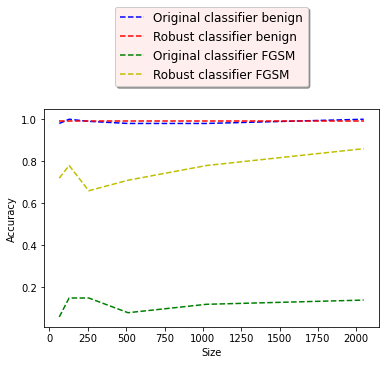

In [21]:
model_size = []

for i in range(6):
  model_size.append(64*(2**i))

fig, ax = plt.subplots()
ax.plot(np.array(model_size), np.array(B_accuracy), 'b--', label='Original classifier benign')
ax.plot(np.array(model_size), np.array(B_tr_accuracy), 'r--', label='Robust classifier benign')
ax.plot(np.array(model_size), np.array(FGM_accuracy), 'g--', label='Original classifier FGSM')
ax.plot(np.array(model_size), np.array(FGM_tr_accuracy), 'y--', label='Robust classifier FGSM')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large', bbox_to_anchor=(0.5,1.5))
legend.get_frame().set_facecolor('#FFEEEEEE')

plt.xlabel('Size')
plt.ylabel('Accuracy')
plt.show()

## References

---

In this cell, add a numbered list of references in your preferred citation format (IEEE or ACM formats are fine, make sure to include URLs for any online sources). You should have numbered references to these sources *in the text of the notebook, too*.


Delete this cell of instructions after you have finished this section.

---